<a href="https://colab.research.google.com/github/WillKWL/Project-NBASeason/blob/master/source/3A_test_set_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [ ]:
from google.colab import drive, files
import os
from joblib import load

import pandas as pd
import numpy as np
pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [20, 5]
import re
import copy
from datetime import datetime

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score, roc_auc_score, roc_curve, precision_recall_curve, PrecisionRecallDisplay, average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler

In [ ]:
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks')

Mounted at /content/drive


# Load environment
- load the following to evaluate model performance on test set:
  - custom clases,
  - functions, 
  - models dumped after hyperparameter tuning ,
  - test set

## Custom classes and functions
- data preparation pipeline before fitting estimator

In [ ]:
# create a custom transformer to fix PFD by replacing it with OPP_PF
class FixPF(BaseEstimator, TransformerMixin):
  def __init__(self, col_drop, col_replace):
    self.col_drop = col_drop
    self.col_replace = col_replace
  
  def fit(self, X, y = None):
    return self
  
  def transform(self, X):
    output = copy.deepcopy(X)
    output[[self.col_drop]] = output[[self.col_replace]]
    self.output_names = output.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names
  
# create a custom transformer to drop columns
class DropCols(BaseEstimator, TransformerMixin):
  def __init__(self, cols_drop):
    self.cols_drop = cols_drop
  
  def fit(self, X, y = None):
    # print([x in X.columns for x in self.cols_drop])
    return self
  
  def transform(self, X):
    output = copy.deepcopy(X)
    output = output.loc[:, [x not in self.cols_drop for x in output.columns]]
    self.output_names = output.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names

# create customer transformer to suppress n_quantile <= n_samples warning
class MyQuantileTransformer(BaseEstimator, TransformerMixin):
  def __init__(self, output_distribution, random_state):
    self.output_distribution = output_distribution
    self.random_state = random_state
  
  def fit(self, X, y = None):
    self.QuantileTransformer = QuantileTransformer(n_quantiles=min(1000, X.shape[0]), # set this to suppress warning due to small dataset
                                                   output_distribution = self.output_distribution,
                                                   random_state = self.random_state).fit(X)
    return self
  
  def transform(self, X):
    output = copy.deepcopy(X)
    output = pd.DataFrame(self.QuantileTransformer.transform(output),
                          columns = X.columns)
    self.output_names = X.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names


# create customer transformer to pass as df instead of array
class MyMinMaxScaler(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
  
  def fit(self, X, y = None):
    self.MinMaxScaler_ = MinMaxScaler().fit(X)
    return self
  
  def transform(self, X):
    output = copy.deepcopy(X)
    output = pd.DataFrame(self.MinMaxScaler_.transform(output),
                          columns = X.columns)
    self.output_names = X.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names

In [ ]:
# create a custom transformer to cluster nba seasons into era
class SeasonSimilarity(BaseEstimator, TransformerMixin):
  def __init__(self, n_clusters = 3, random_state = None, best_silh = False):
    self.n_clusters = n_clusters
    self.random_state = random_state
    self.best_silh = best_silh
  
  def fit(self, X, y = None, sample_weight = None, plot_silh = False):
    self.feature_names_in_ = X.columns.values
    self.index_names = X.sort_index().index.values
    
    # find best k number of clusters based on silhouette score
    if self.best_silh:
      # test performance with silhouette score (distance from one's center and from other centers) from 2 to 10 clusters
      # don't consider tuning k as hyperparameter because silhouette score is more intuitive
      # e.g. clustering based on records from 1996 to 2022 (full range) vs clustering based on records from 2010 to 2022 (1st fold)
      k_range = np.arange(2,11,1)
      silh_scores = []
      for k in range(2,11):
        self.n_clusters = k
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        silh_scores.append(silhouette_score(X, self.kmeans_.labels_))
      
      max_k = k_range[np.argmax(silh_scores)]
      max_silh = max(silh_scores)
      self.n_clusters = max_k    

      # plot silhouette scores for 2 - 10 clusters
      if plot_silh:
        plt.plot(k_range, silh_scores)
        plt.xlabel("Number of clusters")
        plt.ylabel("Silhouette score")
        plt.title(f"optimal no. of cluster = {max_k}, silhouette score = {max_silh:0.4f}")
        plt.show()
    
    self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
    self.kmeans_.fit(X, sample_weight=sample_weight)
    return self
  
  def transform(self, X):
    # Soft Clustering: each column = distance to cluster i
    X_clusterdist = pd.DataFrame(self.kmeans_.transform(X),
                                 columns=[f"ERA_{i}" for i in range(self.n_clusters)])
    # Scaling: Quantile transform the cluster distances like other numerical columns
    # X_clusterdist = pd.DataFrame(MyQuantileTransformer(output_distribution="normal", random_state=42).fit_transform(X_clusterdist),
    #                              columns=[f"ERA_{i}" for i in range(self.n_clusters)])
    # Scaling: MinMaxScale transform the cluster distances like other numerical columns
    X_clusterdist = pd.DataFrame(MyMinMaxScaler().fit_transform(X_clusterdist),
                                 columns=[f"ERA_{i}" for i in range(self.n_clusters)])
    # merge with numerical columns to return
    output = pd.concat([X, X_clusterdist], axis=1)
    self.output_features = output.columns.values
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_features

## Models after hyperparameter tuning

In [ ]:
tuned_models = {}
time_list = []
time_diff = []
match_pattern = '_tuned_AP_class_balanced_(\w+).joblib'

for time in [re.search(match_pattern, x).group(1) for x in os.listdir() if re.search(match_pattern, x) is not None]:
  time_diff.append(datetime.now() - datetime.strptime(time, "%Y%m%d_%H%M%S"))
  time_list.append(time)

latest = time_list[np.argmin(time_diff)]
for file in [x for x in os.listdir() if (re.search(match_pattern, x) is not None) and latest in x]:
  model = load(file)
  tuned_models[model.best_estimator_.steps[-1][0]] = model
  print(model.best_estimator_.steps[-1][0], "class balanced AP loaded")

xgb ADASYN AP loaded
forest ADASYN AP loaded
xgbrf ADASYN AP loaded
svc ADASYN AP loaded
sgd ADASYN AP loaded


In [ ]:
# pull the CV AP results from RandomizedSearchCV
tuned_AP = []
for clf_name, model in tuned_models.items():
  # tuned_AP.append(cross_val_score(model.best_estimator_, season, y_test, cv = 10, scoring='average_precision'))
  cv_AP_colindex = [i for i, x in enumerate(model.cv_results_.keys()) if re.search('split\w+_test_score', x) is not None]
  tuned_AP.append(pd.DataFrame(model.cv_results_).iloc[model.best_index_,cv_AP_colindex].values)

In [ ]:
# sort the models and plot the spread of CV AP scores
mean_tuned_AP = [np.mean(AP) for AP in tuned_AP]
sorted_tuned_AP = [i for _, i in sorted(zip(mean_tuned_AP, tuned_AP), reverse = True)]
sorted_tuned_clf = [i for _, i in sorted(zip(mean_tuned_AP, tuned_models.keys()), reverse = True)]

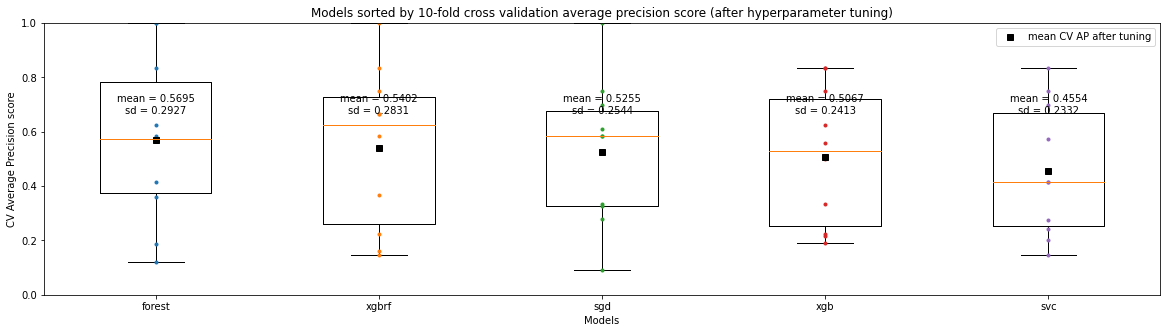

In [ ]:
plt.boxplot(sorted_tuned_AP, labels=sorted_tuned_clf)
# add dots for CV AP scores
for i, AP in enumerate(sorted_tuned_AP):
  plt.plot([i+1]*len(AP), AP, ".")
  plt.annotate(f"mean = {np.mean(AP):0.4f}\nsd = {np.std(AP):0.4f}",(i+1, 0.7), ha = 'center', va = 'center')

plt.plot([*range(1,len(sorted_tuned_AP)+1,1)], sorted(mean_tuned_AP, reverse=True), 
         "ks", label = 'mean CV AP after tuning')
plt.legend()
plt.title(f"Models sorted by 10-fold cross validation average precision score (after hyperparameter tuning)")
plt.xlabel("Models")
plt.ylim(0,1)
plt.ylabel("CV Average Precision score")
plt.show()

## Pick best model

In [ ]:
best_model = tuned_models['sgd'].best_estimator_

In [ ]:
best_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('fixpf',
                                                                   FixPF(col_drop='PFD',
                                                                         col_replace='OPP_PF')),
                                                                  ('dropcols',
                                                                   DropCols(cols_drop=['GP',
                                                                                       'W',
                                                                                       'L',
                                                                                       'W_PCT',
                                                                                       'MIN',
                                                                                       'FGM',
   

## Test set

In [ ]:
test_set = pd.read_pickle("https://github.com/WillKWL/PublicData/blob/main/raw/nba_pre_all_star_vs_playoff_test_comprehensive.pkl?raw=true")
# make a copy and split X and y
X_test = test_set.drop(columns = "PLAYOFF_RANKING").reset_index(drop = True).copy(deep = True)
y_test = test_set[["PLAYOFF_RANKING"]].values.reshape(-1,)

In [ ]:
X_test.shape

(143, 96)

## Predicted Probabilities
- right-skewed distribution due to class imbalance

In [ ]:
# prediction
y_probs = best_model.predict_proba(X_test)[:,1]

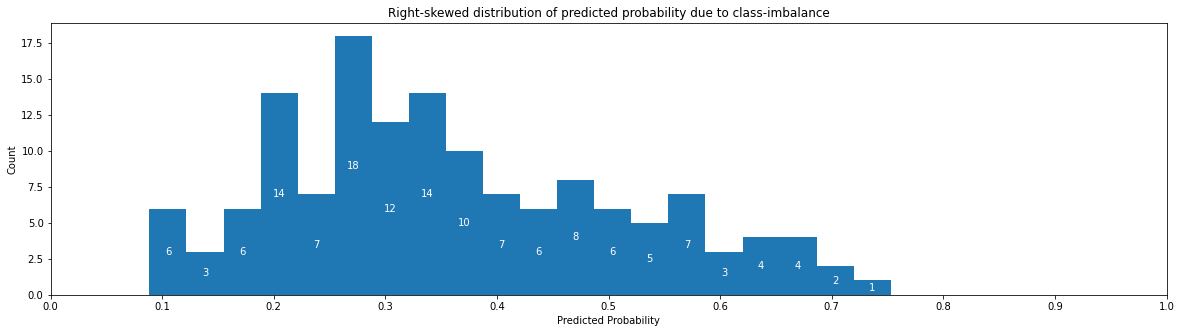

In [ ]:
fig, ax = plt.subplots(1,1)
ax.hist(y_probs, bins = 20)
for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f"{height:0.0f}",
                xy=(rect.get_x() + rect.get_width() / 2, height/2),
                xytext=(0, 0),  # 3 points vertical offset
                textcoords="offset points",
                color = 'white',
                ha='center', va='center')
plt.xlim(0,1)
plt.xticks(np.arange(0,1.1,0.1))
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.title("Right-skewed distribution of predicted probability due to class-imbalance")
plt.show()

# Performance evaluation

## Precision-Recall curve
- Prefer precision-recall over ROC curve
  - For imbalanced data, precision-recall curve provides a more accurate picture on TP, while ROC curve can be too optimistic due to TN
- Precision > Recall
  - As a team manager or as a fan, precision of the prediction matters more than recall

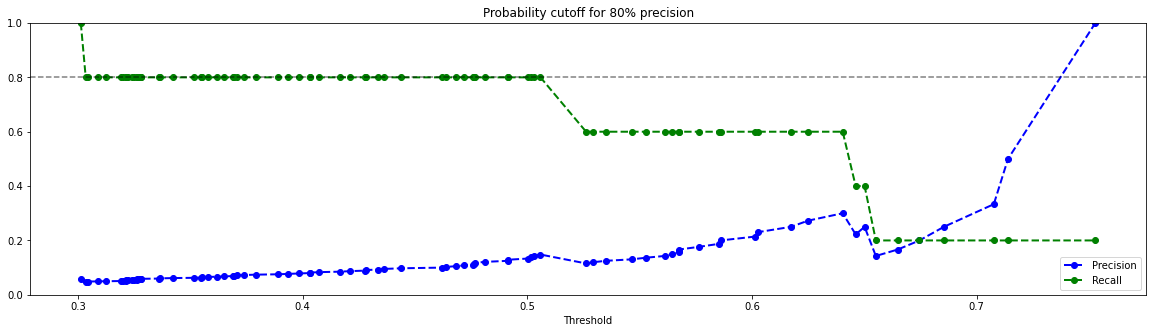

In [ ]:
# due to class imbalance, the thresholds for high precision become really sparse -> difficult to decide a decision threshold 
# using over-sampling or SMOTE didn't help in high-dimensional data (no near neighbors in high dimension)

precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
plt.plot(thresholds, precisions[:-1], 'b--o', label = "Precision", linewidth = 2)
plt.plot(thresholds, recalls[:-1], "g--o", label = "Recall", linewidth = 2)
plt.xlabel("Threshold")
plt.ylim(0,1)
plt.axhline(0.8, ls='--', c='k', alpha=0.5)
plt.title("Probability cutoff for 80% precision")
plt.legend()
plt.show()

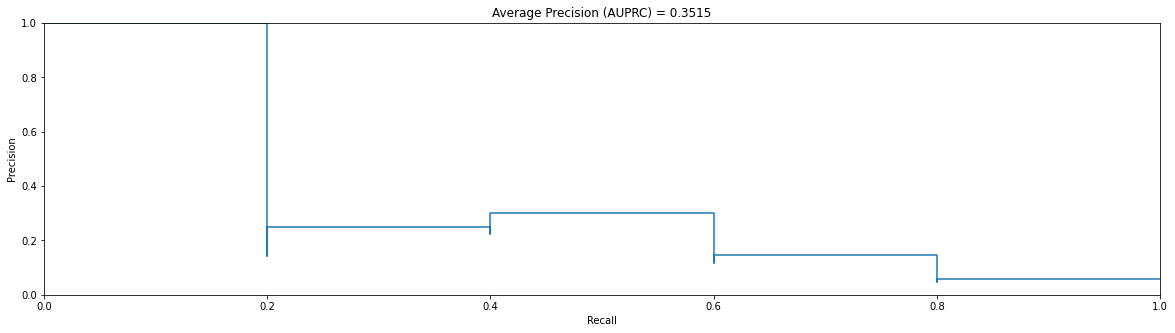

In [ ]:
PrecisionRecallDisplay(precision=precisions, recall=recalls).plot()
plt.xlim(0,1)
plt.ylim(0,1)
plt.title(f"Average Precision (AUPRC) = {average_precision_score(y_test, y_probs):0.4f}")
plt.show()

## Average Precision
- Average precision = area under precision-recall curve
  - [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score)

In [ ]:
CV_model = tuned_models[best_model.steps[-1][0]]
cv_result = pd.DataFrame(CV_model.cv_results_)
cv_AP_colindex = [i for i, x in enumerate(cv_result.columns.values) if re.search('split\w+_test_score', x) is not None]
best_CV_AP = pd.DataFrame(CV_model.cv_results_).iloc[CV_model.best_index_,cv_AP_colindex].values

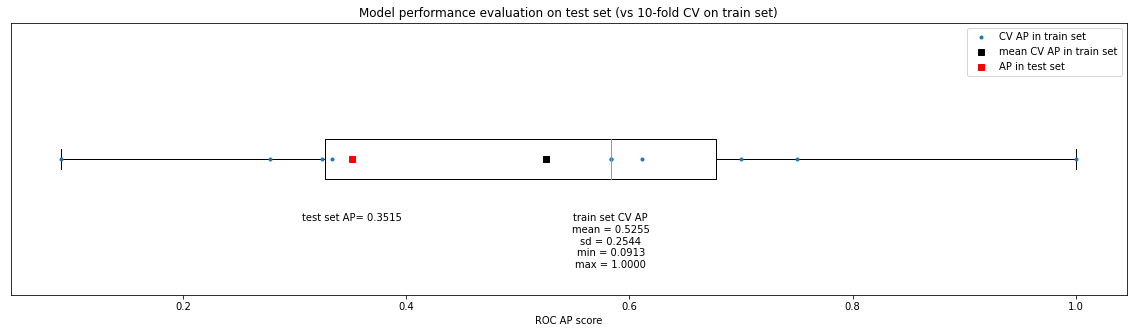

In [ ]:
# plot CV AP scores on train set
plt.boxplot(best_CV_AP, labels = [""], vert=False)
plt.plot(best_CV_AP, [1]*len(best_CV_AP), ".", label='CV AP in train set')
plt.annotate(f"train set CV AP\n" + 
             f"mean = {np.mean(best_CV_AP):0.4f}\n" + 
             f"sd = {np.std(best_CV_AP):0.4f}\n" + 
             f"min = {np.min(best_CV_AP):0.4f}\n" + 
             f"max = {np.max(best_CV_AP):0.4f}",
             (np.median(best_CV_AP), 0.8), 
              ha = 'center', va = 'top')
plt.plot(np.mean(best_CV_AP), [1], "ks", label = 'mean CV AP in train set')

# compare with AP score on test set
test_AP = average_precision_score(y_test, y_probs)
plt.plot(test_AP, [1], "rs", label = 'AP in test set')
plt.annotate(f"test set AP= {test_AP:0.4f}",(test_AP, 0.8), 
              ha = 'center', va = 'top')

plt.legend()
plt.title(f"Model performance evaluation on test set (vs 10-fold CV on train set)")
plt.xlabel("ROC AP score")
# plt.xlim(0.5,1)
plt.ylabel("")
plt.yticks([])
plt.show()

## Lift and gain chart

In [ ]:
temp_df = pd.DataFrame({
    'y': y_test,
    'prob': y_probs
})
temp_df.sort_values('prob', ascending=False, inplace=True)
temp_df['decile'] = pd.qcut(temp_df['prob'],10,labels=[i for i in np.arange(10,0,-1)])

In [ ]:
lift_n_gain = temp_df.groupby('decile').agg({'y': ['sum']}).sort_index(ascending=False)
lift_n_gain.columns = ['sum_of_positive_cases_identified']
lift_n_gain['gain'] = lift_n_gain[['sum_of_positive_cases_identified']].apply(lambda x: x.cumsum() / x.sum())
lift_n_gain['lift'] = lift_n_gain['gain'] / (lift_n_gain.index.values.astype(int) / 10)

In [ ]:
lift_n_gain

,sum_of_positive_cases_identified,gain,lift
decile,,,
1,3,0.6,6.000000
2,1,0.8,4.000000
3,0,0.8,2.666667
4,0,0.8,2.000000
5,0,0.8,1.600000
6,1,1.0,1.666667
7,0,1.0,1.428571
8,0,1.0,1.250000
9,0,1.0,1.111111


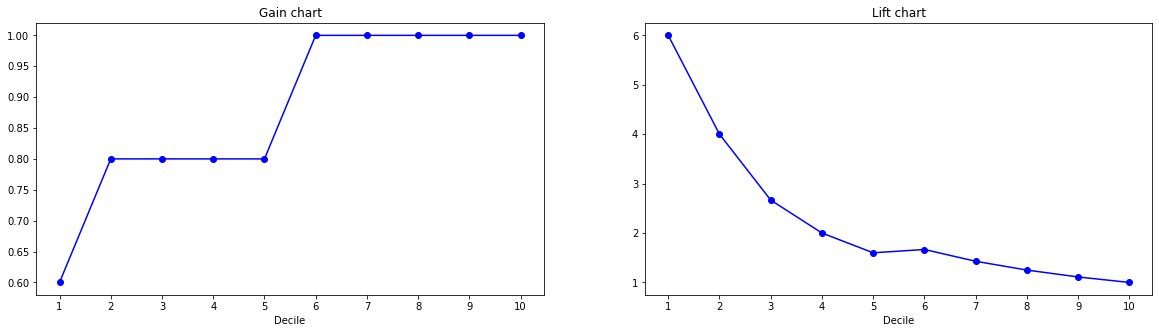

In [ ]:
fig, axes = plt.subplots(1,2)
axes[0].plot(np.arange(1,11,1), lift_n_gain['gain'].values, 'bo-')
axes[1].plot(np.arange(1,11,1), lift_n_gain['lift'].values, 'bo-')
axes[0].set_title('Gain chart')
axes[1].set_title('Lift chart')
for ax in axes:
  ax.set_xticks(np.arange(1,11,1))
  ax.set_xlabel("Decile")
plt.show()

## Coefficients

Number of original features: 
96
['TEAM_ID' 'TEAM_NAME' 'GP' 'W' 'L' 'W_PCT' 'MIN' 'FGM' 'FGA' 'FG_PCT'
 'FG3M' 'FG3A' 'FG3_PCT' 'FTM' 'FTA' 'FT_PCT' 'OREB' 'DREB' 'REB' 'AST'
 'TOV' 'STL' 'BLK' 'BLKA' 'PF' 'PFD' 'PTS' 'PLUS_MINUS' 'CFID' 'CFPARAMS'
 'AST_PCT' 'AST_RATIO' 'AST_TO' 'DEF_RATING' 'DREB_PCT' 'EFG_PCT'
 'NET_RATING' 'OFF_RATING' 'OREB_PCT' 'PACE' 'PACE_PER40' 'PIE' 'POSS'
 'REB_PCT' 'TM_TOV_PCT' 'TS_PCT' 'OPP_PTS_2ND_CHANCE' 'OPP_PTS_FB'
 'OPP_PTS_OFF_TOV' 'OPP_PTS_PAINT' 'PTS_2ND_CHANCE' 'PTS_FB' 'PTS_OFF_TOV'
 'PTS_PAINT' 'FTA_RATE' 'OPP_EFG_PCT' 'OPP_FTA_RATE' 'OPP_OREB_PCT'
 'OPP_TOV_PCT' 'PCT_AST_2PM' 'PCT_AST_3PM' 'PCT_AST_FGM' 'PCT_FGA_2PT'
 'PCT_FGA_3PT' 'PCT_PTS_2PT' 'PCT_PTS_2PT_MR' 'PCT_PTS_3PT' 'PCT_PTS_FB'
 'PCT_PTS_FT' 'PCT_PTS_OFF_TOV' 'PCT_PTS_PAINT' 'PCT_UAST_2PM'
 'PCT_UAST_3PM' 'PCT_UAST_FGM' 'OPP_AST' 'OPP_BLK' 'OPP_BLKA' 'OPP_DREB'
 'OPP_FG3A' 'OPP_FG3M' 'OPP_FG3_PCT' 'OPP_FGA' 'OPP_FGM' 'OPP_FG_PCT'
 'OPP_FTA' 'OPP_FTM' 'OPP_FT_PCT' 'OPP_OREB' 'OPP_PF'

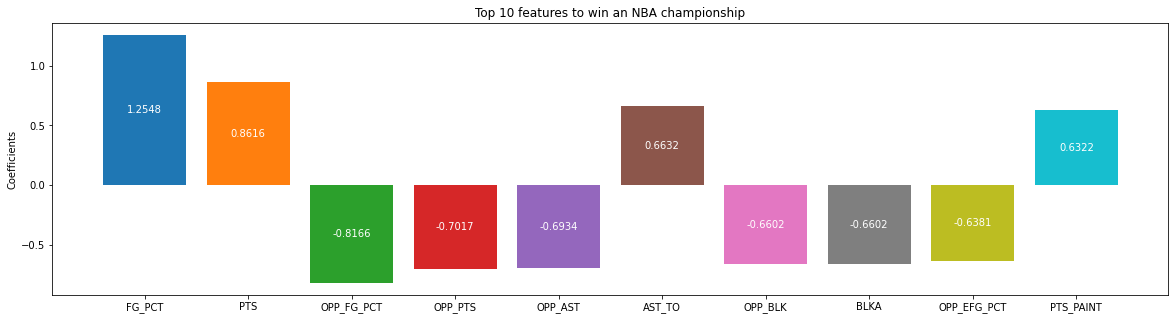

In [ ]:
# original features
features_in = X_test.columns.values # cannot use features_in here since data_cleaning pipeline is wrapped in SeasonSimilarity instead of part of data_preparation pipeline
print(f"Number of original features: \n{len(X_test.columns.values)}")
print(features_in, "\n")

# sparse features after feature selection with L1 penalty in data_preparation pipeline
features_out = best_model[:-1].get_feature_names_out() 
print(f"Number of features after feature engineering, scaling and selection: \n{len(features_out)}")
print(features_out, "\n")

# non-zero (signficant) features after regularization in fitting estimator
try:
  coef = best_model.steps[-1][1].feature_importances_
except:
  coef = best_model.steps[-1][1].coef_[0]
print(f"Number of features after fitting estimator with regularization: \n{np.count_nonzero(coef)}")
features_non_zero = [features_out[loc] for loc in np.nonzero(coef)[0]]
coef_non_zero = [np.around(coef[loc], decimals=4) for loc in np.nonzero(coef)[0]]
print(f"features = {[feature_ for _, feature_ in sorted(zip(np.abs(coef_non_zero), features_non_zero), reverse=True)]}")
print(f"coefficient = {[coef_ for _, coef_ in sorted(zip(np.abs(coef_non_zero), coef_non_zero), reverse=True)]}")

abs_coef = np.abs(coef)
fig, ax = plt.subplots(1,1)
top_n = 10
for i, (_, coef, name) in enumerate(sorted(zip(abs_coef, coef, features_out), reverse=True)[:top_n]):
  ax.bar(name, coef)
for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f"{height:0.4f}",
                xy=(rect.get_x() + rect.get_width() / 2, height/2),
                xytext=(0, 0),  # 3 points vertical offset
                textcoords="offset points",
                color = 'white',
                ha='center', va='center')
plt.title(f"Top {top_n} features to win an NBA championship")
plt.ylabel("Coefficients")
plt.show()

## Confusion matrix

In [ ]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report

In [ ]:
# to achieve a precision of 80% or more
precision_pct = 0.8

In [ ]:
# due to class imbalance in a small test set, 
# the threshold intervals are so sparse that it becomes hard to achieve exactly 80%
idx_for_chosen_precision = (precisions >= precision_pct).argmax()
chosen_threshold = thresholds[idx_for_chosen_precision]
y_predict = (best_model.predict_proba(X_test)[:,1] >= chosen_threshold)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       138
           1       1.00      0.20      0.33         5

    accuracy                           0.97       143
   macro avg       0.99      0.60      0.66       143
weighted avg       0.97      0.97      0.96       143



In [ ]:
# only 1 instance was predicted and correctly identified as positive (winning a championship)
confusion_matrix(y_test, y_predict)

array([[138,   0],
       [  4,   1]])

## ROC curve and AUC score
- ROC AUC score is high but it is overly optimistic given it replaces precision in precision-recall curve with False Positive Rate
- With class imbalance in our dataset, the importance of True Negatives is exaggerated in ROC AUC curve

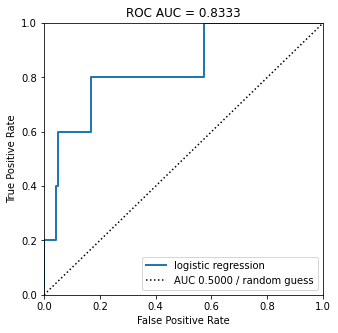

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, linewidth = 2, label = f"logistic regression")
plt.plot([0,1], [0,1], 'k:', label = "AUC 0.5000 / random guess")
plt.xlim(0,1)
plt.ylim(0,1)
plt.title(f"ROC AUC = {roc_auc_score(y_test, y_probs):0.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.show()

## Most probable champions in full dataset

In [ ]:
train_set = pd.read_pickle("https://github.com/WillKWL/PublicData/blob/main/raw/nba_pre_all_star_vs_playoff_train_comprehensive.pkl?raw=true")

In [ ]:
full_set = pd.concat([train_set, test_set])

In [ ]:
X_full = full_set.drop(columns = "PLAYOFF_RANKING").reset_index(drop = True).copy(deep = True)
y_full = full_set[['PLAYOFF_RANKING']].copy()

In [ ]:
# ranking players and teams by probability of winning a championship
most_probable = full_set.iloc[best_model.predict_proba(X_full)[:,1].argsort()[::-1],][['TEAM_NAME','SEASON',"PLAYOFF_RANKING"]]
most_probable['prob'] = sorted(best_model.predict_proba(X_full)[:,1], reverse=True)
most_probable = most_probable.loc[most_probable['PLAYOFF_RANKING'] == 0]
most_probable.head(10)

,TEAM_NAME,SEASON,PLAYOFF_RANKING,prob
567,San Antonio Spurs,2015-16,0,0.791641
584,Golden State Warriors,2015-16,0,0.787582
248,Miami Heat,2004-05,0,0.738128
330,Phoenix Suns,2007-08,0,0.729235
517,Miami Heat,2013-14,0,0.724849
271,Phoenix Suns,2005-06,0,0.722167
684,Milwaukee Bucks,2019-20,0,0.721477
750,Phoenix Suns,2021-22,0,0.720531
300,Phoenix Suns,2006-07,0,0.713994
428,Boston Celtics,2010-11,0,0.707664
